# Análisis de los datos del patrón de diffracción para la vara de acero

## 1) Calibramos la imagen

Importamos librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize
from scipy import signal
from scipy import ndimage
import matplotlib


Importamos imagen que usamos para calibrar cm/px

In [12]:
im_calibracion = imageio.imread('~/facultad/labo_4/git_labo_4/informe_1/young_estatico/data/datos_acero/papela.jpg')

calib_rojo = im_calibracion[:,:,0]
calib_verde = im_calibracion[:,:,1]
calib_azul = im_calibracion[:,:,2]

Visualizo las imágenes para ver cual se ve mejor y quedarme con esa para calibrar

In [13]:
%matplotlib qt

fig, ax = plt.subplots(3, figsize=(12,20))
ax1, ax2, ax3 = ax

#recorto las imágenes
calib_rojo = calib_rojo[1250:2250,630:1630]
calib_verde = calib_verde[1250:2250,630:1630]
calib_azul = calib_azul[1250:2250,630:1630]

#muestro las imágenes
ax1.imshow(calib_rojo)
ax2.imshow(calib_verde)
ax3.imshow(calib_azul)
plt.show()


Me quedo con la imagen roja. Ahora la roto para que quede vertical y la vuelvo a recortar

In [14]:
calib_rojo = ndimage.rotate(calib_rojo, 4) #Roto la imagen en 4 grados
calib_rojo = calib_rojo[170:1000,400:600] #Recorto la imagen
fig, ax = plt.subplots(1, figsize=(10,10)) #Grafico
ax.imshow(calib_rojo)
plt.show()

Ahora con la imagen rotada y recortada tomo los puntos de las esquinas de la grilla y los guardo en una lista

In [15]:
plt.imshow(calib_rojo)
puntos_grilla = plt.ginput(15, timeout=60)
plt.show()

Ahora que tengo los puntos de la grilla calculo la cantidad de pixeles que hay por centímetro

In [16]:
puntos_grilla = np.array(puntos_grilla)
puntos_grilla = puntos_grilla[:,1] #Me quedo sólo con los puntos de la grilla en y
diferencias = np.diff(puntos_grilla)
escala = np.mean(diferencias)
error = np.std(diferencias)
print("En la imagen hay",escala,"+-",error, "px/cm")

En la imagen hay 53.054988229057855 +- 1.198033524284348 px/cm


## 2) Buscamos los mínimos del patrón de difracción en las imágenes

Ahora que tengo la escala importo las imágenes a analizar. También hago una lista con las masas que se colocaron en cada archivo

In [17]:
imagenes = []
nombres_de_los_archivos = ["a0", "a00", "a1", "a2", "a3", "a4", "a5"]
masas = [3.0912, 1.0043, 4.8188, 6.9318, 9.0212, 11.0755, 13.6564] #en gramos y su error es 0.0005g

for nombre in nombres_de_los_archivos:
    imagenes.append(imageio.imread("~/facultad/labo_4/git_labo_4/informe_1/young_estatico/data/datos_acero/%s.jpg" %nombre))
    

Recorto las imágenes

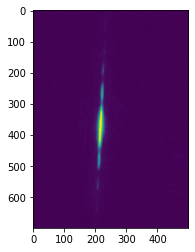

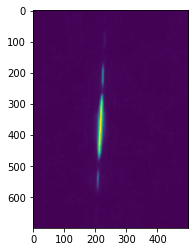

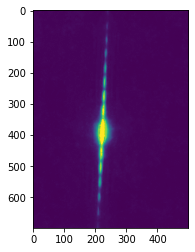

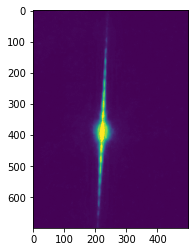

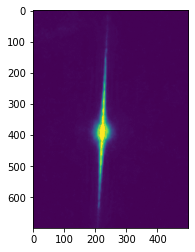

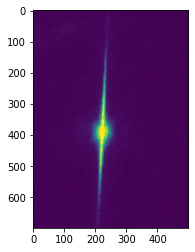

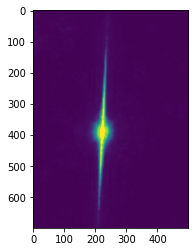

In [18]:
%matplotlib inline

for index, imagen in enumerate(imagenes):
    imagenes[index] = imagen[1400:2100,1050:1550]
    imagenes[index] = imagenes[index][:,:,0] #me quedo con la componente roja
    plt.imshow(imagenes[index])
    plt.show()


Roto las imágenes

In [19]:
angulos = [2.7, 2.5, 2.9, 2.8, 2.8, 2.8, 2.8]
for index, imagen in enumerate(imagenes):
    angulo = angulos[index]
    imagenes[index] = ndimage.rotate(imagen, angulo)


Chequeo que estén bien rotadas

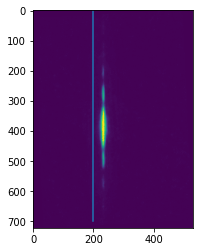

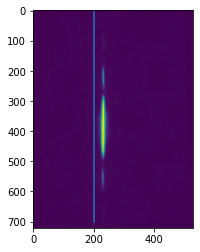

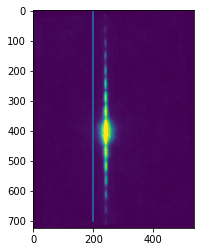

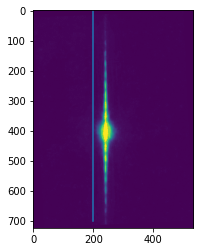

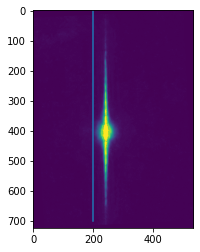

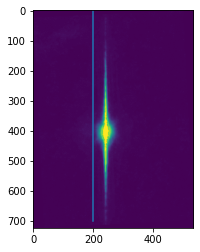

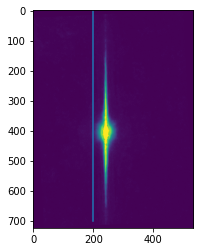

In [20]:
for imagen in imagenes:
    plt.imshow(imagen)
    plt.plot([200,200],[0,700])
    plt.show()

Sumo todos los valores de las filas

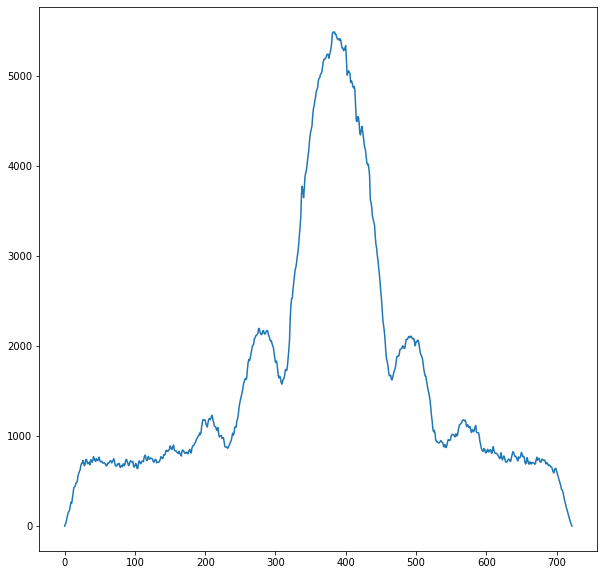

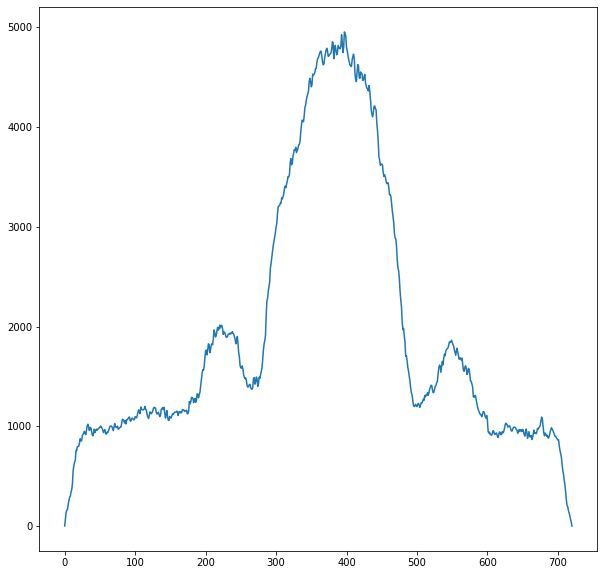

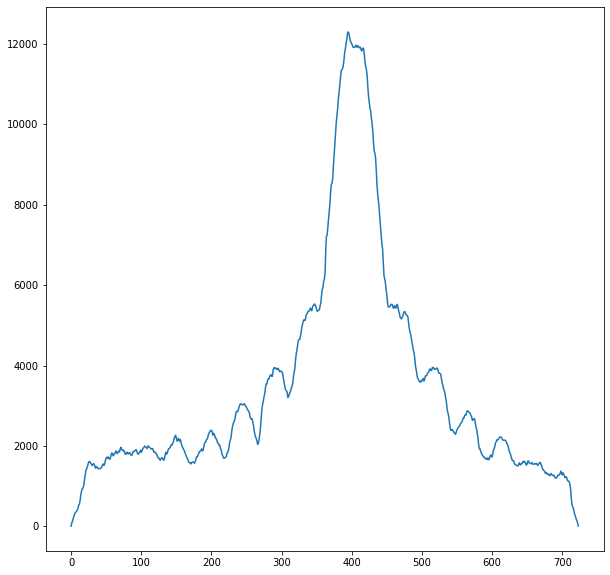

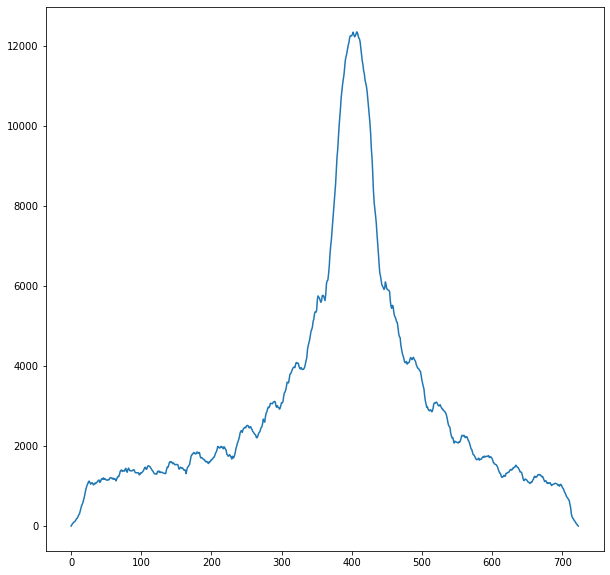

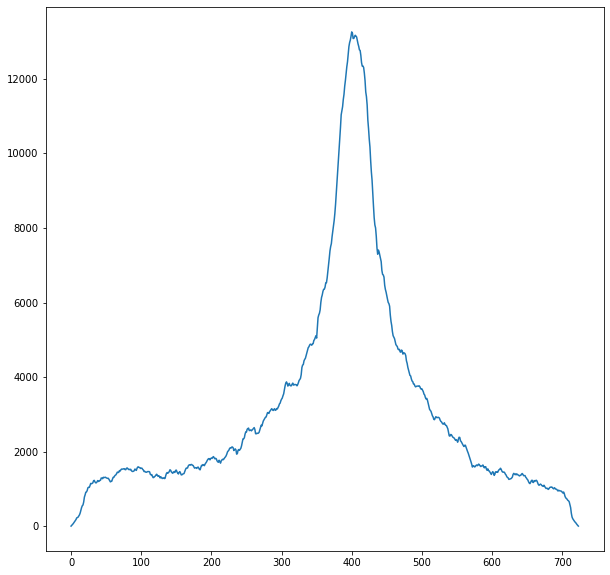

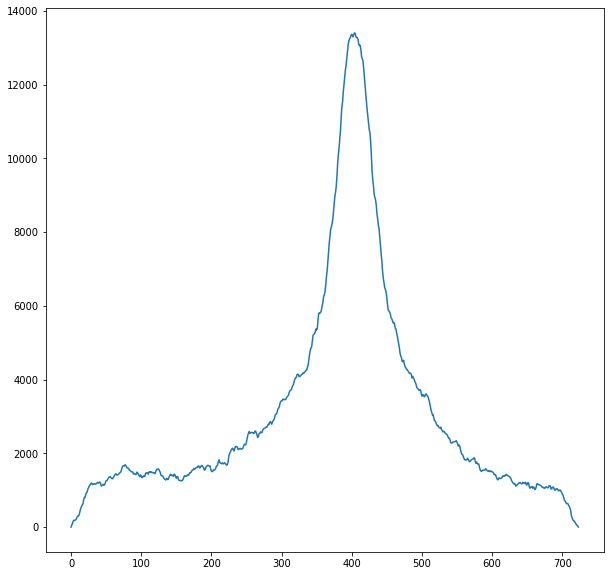

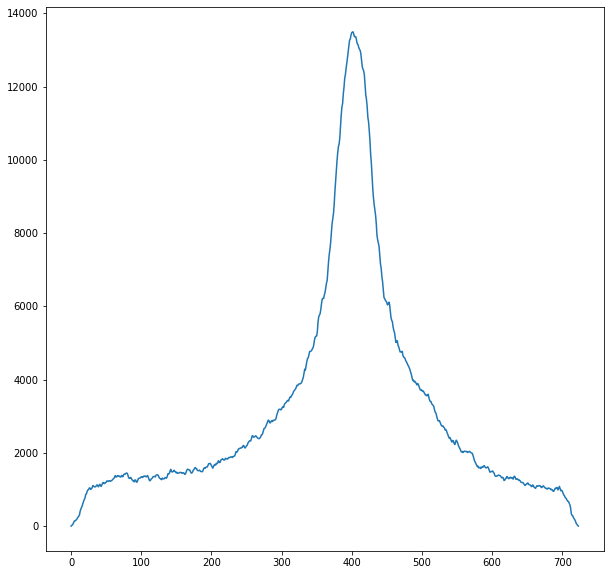

In [21]:
imagenes_colapsadas = []

for imagen in imagenes:
    
    imagen_colapsada = []
    
    for fil in range(imagen.shape[0]):
        imagen_colapsada.append(np.sum(imagen[fil, :]))
    
    plt.figure(figsize=(10,10))
    plt.plot(imagen_colapsada)
    plt.show()
    imagenes_colapsadas.append(imagen_colapsada)



Suavizo estas funciones tomando promedios adyacentes

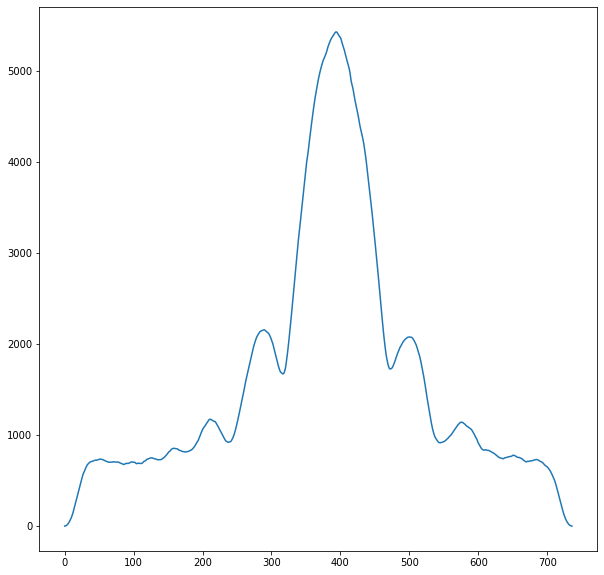

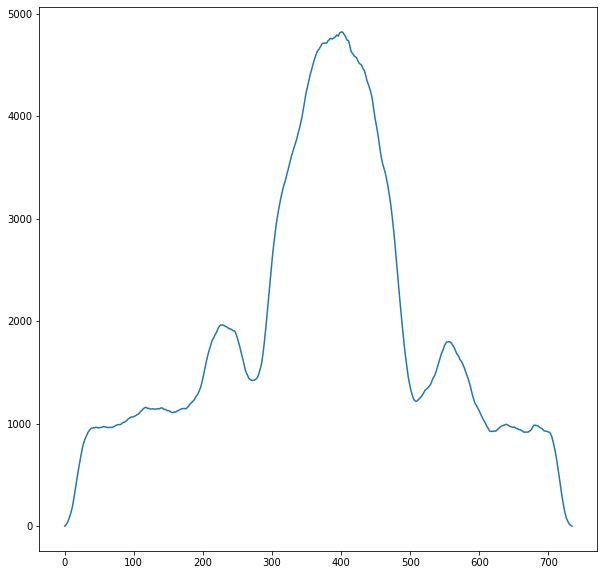

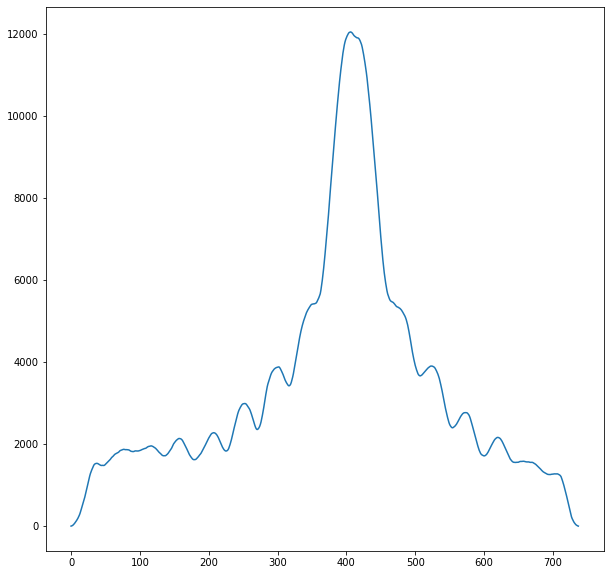

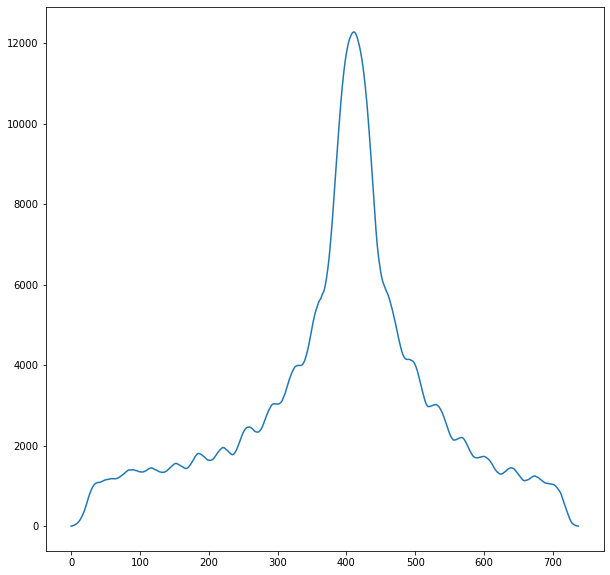

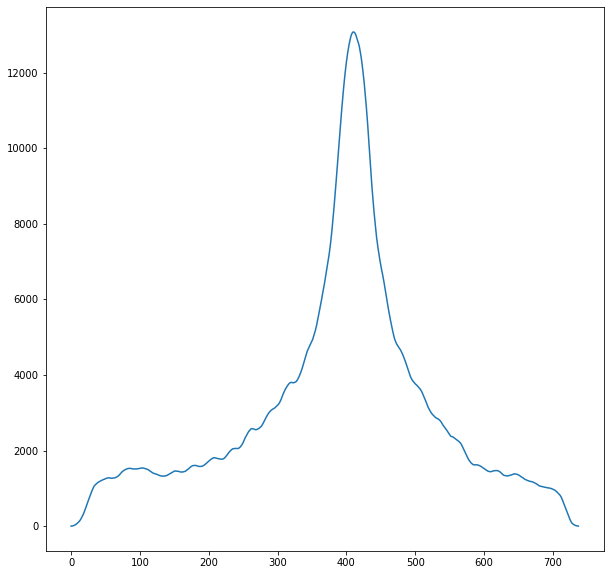

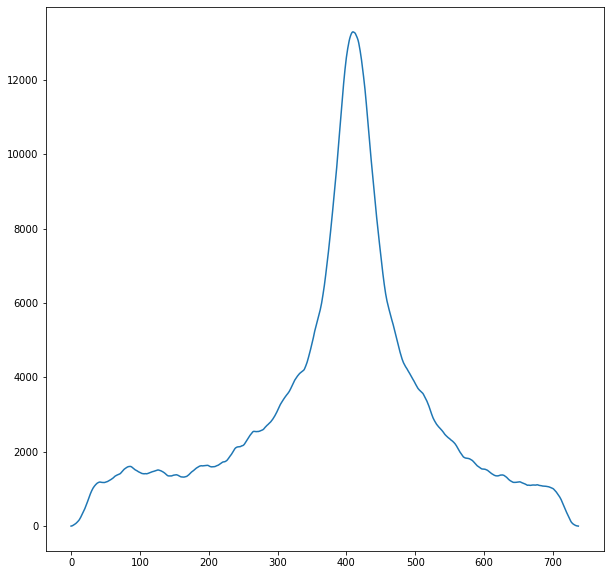

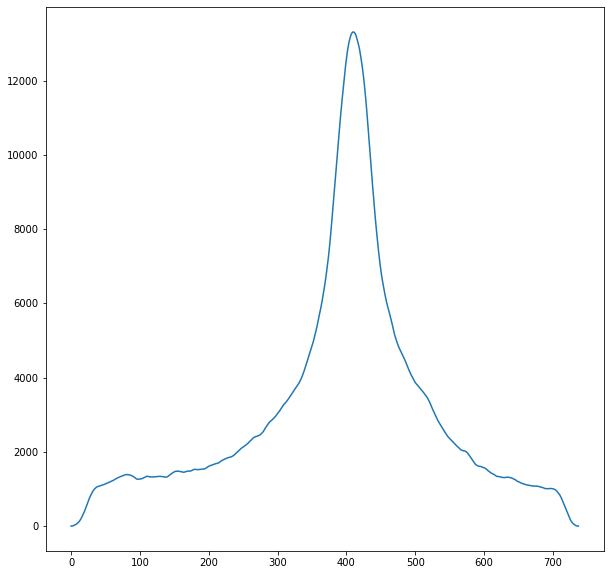

In [22]:
imagenes_suavizadas = []
for imagen in imagenes_colapsadas:
    plt.figure(figsize=(10,10))
    suavizada = np.convolve(imagen, np.ones(15)/15)
    imagenes_suavizadas.append(suavizada)
    plt.plot(suavizada)
    plt.show()

Busco los mínimos de los datos de las imágenes

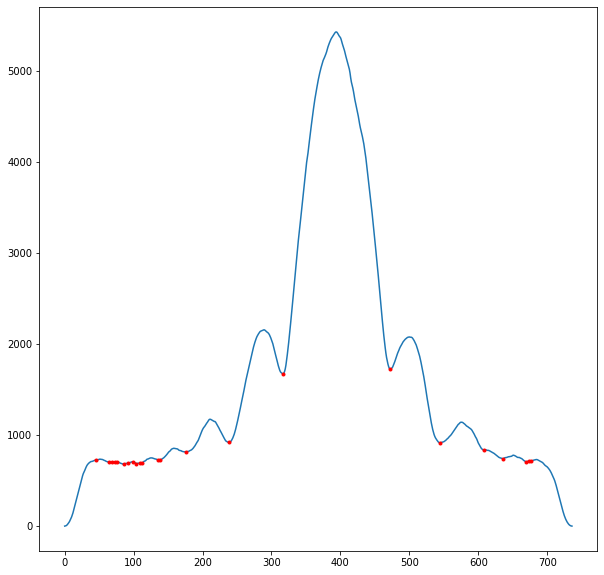

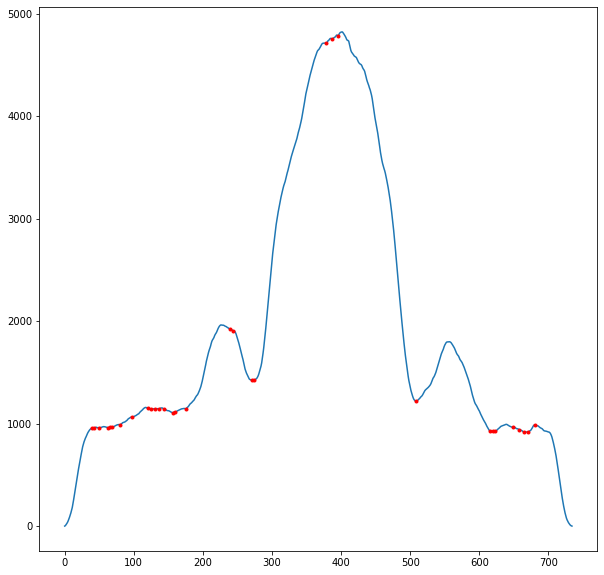

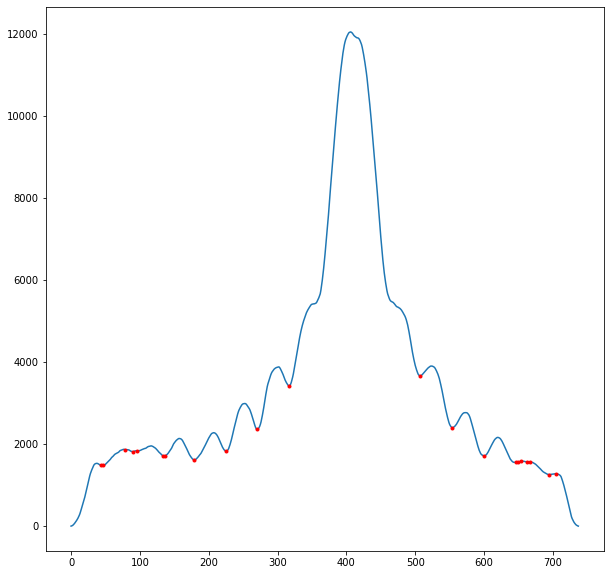

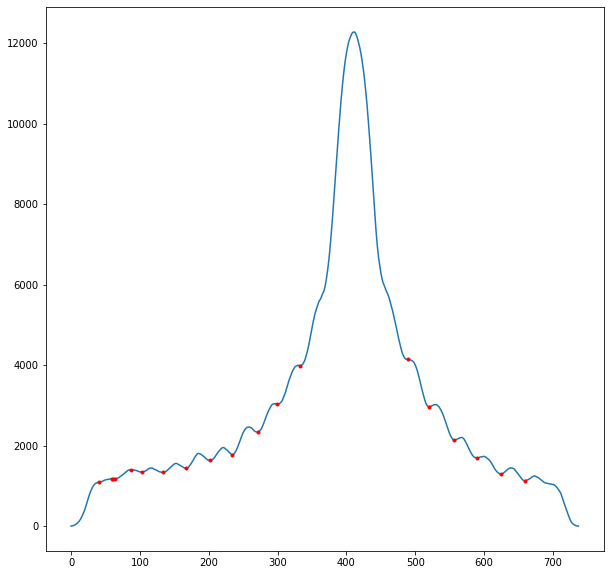

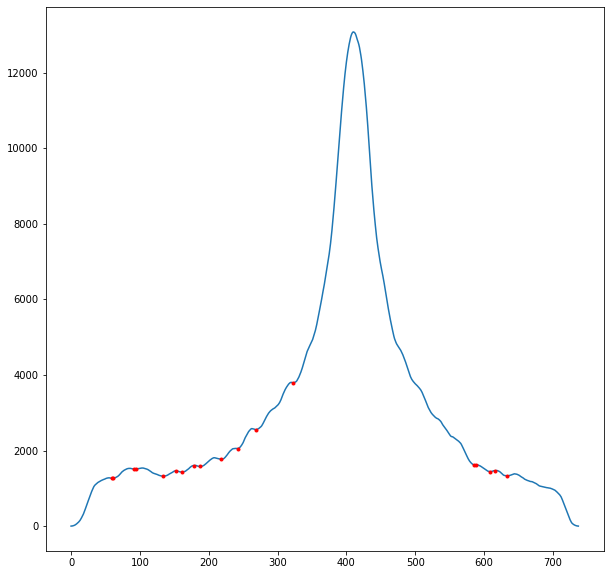

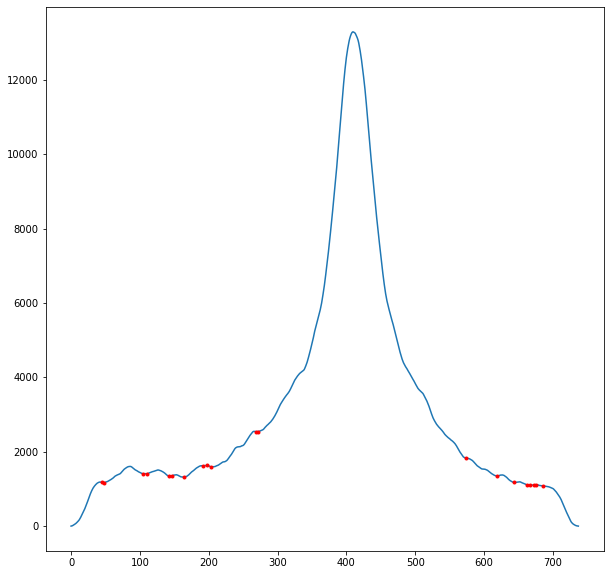

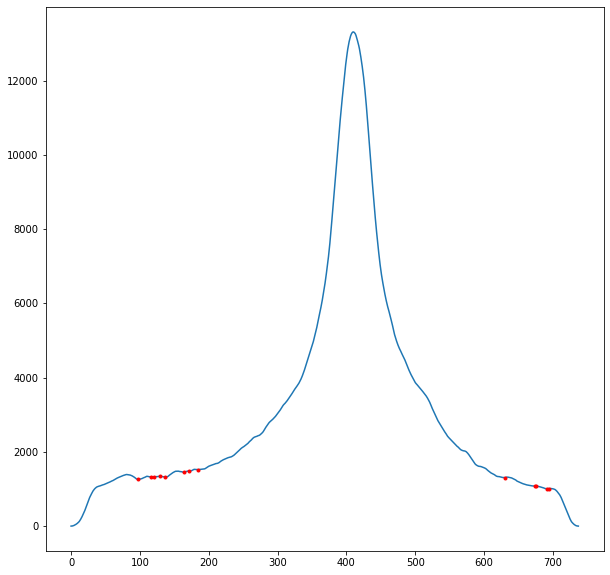

In [62]:
from scipy.signal import argrelextrema #Esta función encuentra máximos o mínimos locales

minimos = []

for imagen in imagenes_suavizadas:
    minimo = argrelextrema(imagen, np.less)
    minimo = np.array(minimo)[0,:]
    minimos.append(minimo)

    plt.figure(figsize=(10,10))
    plt.plot(imagen)
    plt.plot(minimo, imagen[minimo], '.r')
    plt.show()

Elimino todos los puntos amontonados que no son mínimos

In [63]:
limites = [[120,620],
           [180,630],
           [120,620],
           [100,700],
           [200,300],
           [1,2],
           [1,2]] #Lista con el inicio y el fin de los puntos que quiero tomar para cada gráfico 

minimos_nuevos = []
for index, minimo in enumerate(minimos):
    minim = limites[index][0]
    maxim = limites[index][1]
    minimo_nuevo = np.where(np.logical_or(minimo < minim, minimo > maxim), np.nan, minimo)
    minimos_nuevos.append(minimo_nuevo[np.logical_not(np.isnan(minimo_nuevo))].astype(int))



Veo que puntos me quedaron

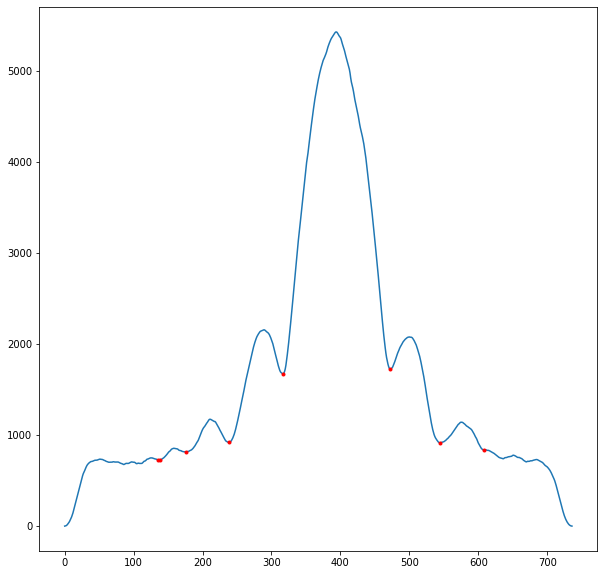

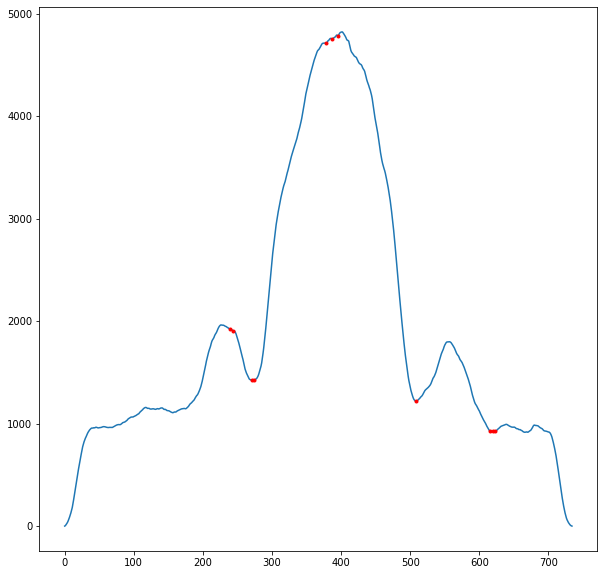

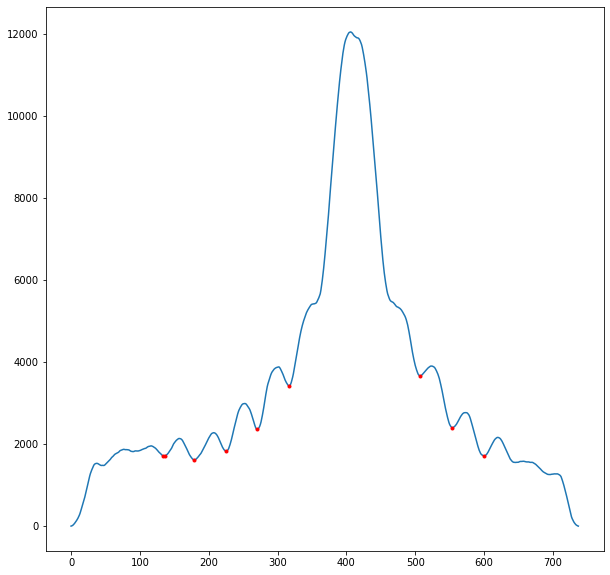

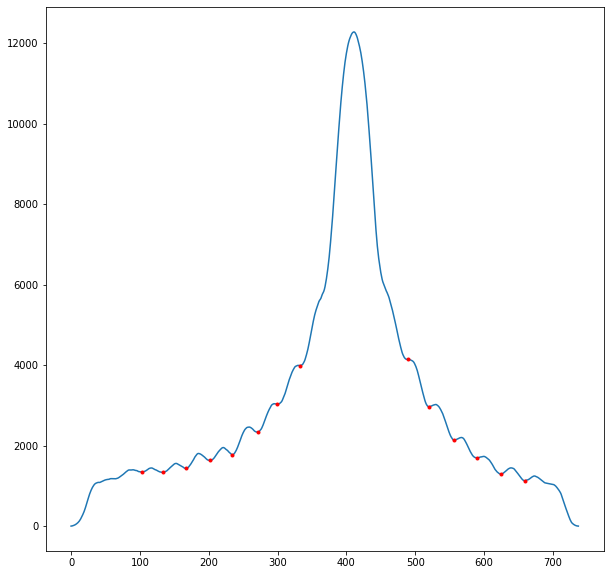

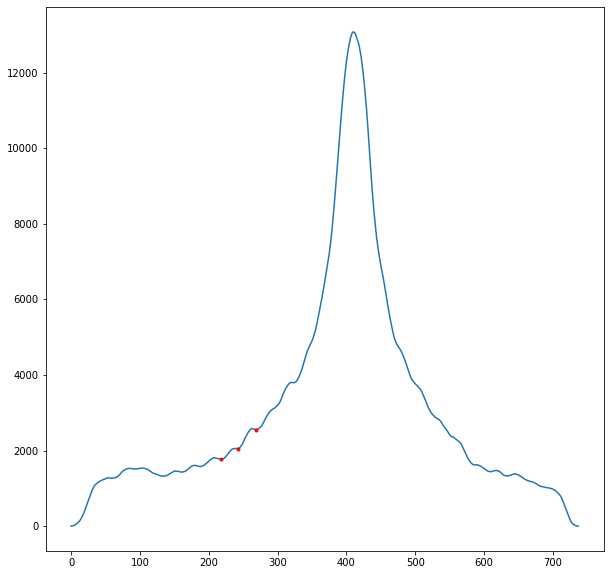

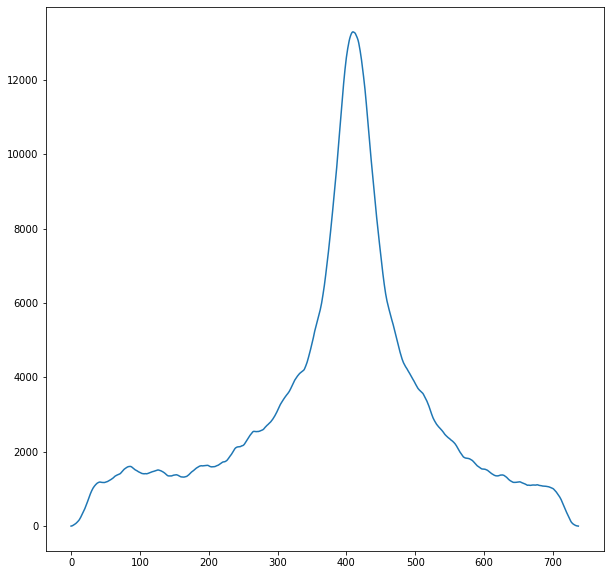

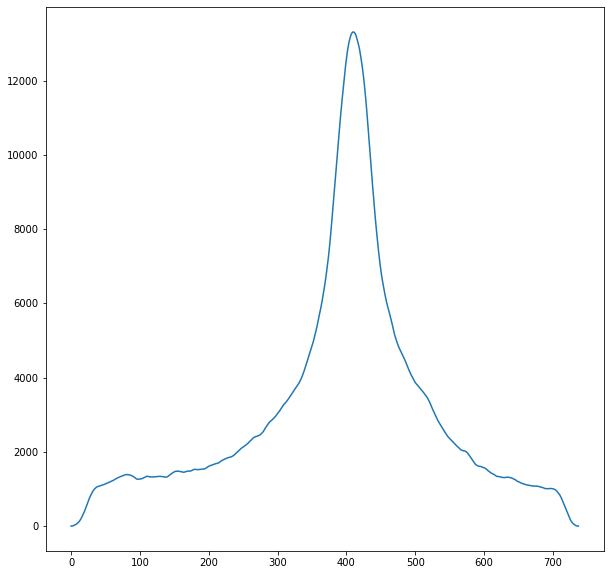

In [64]:
for index, imagen in enumerate(imagenes_suavizadas):
    plt.figure(figsize=(10,10))
    plt.plot(imagen)
    plt.plot(minimos_nuevos[index], imagen[minimos_nuevos[index]], '.r')
    plt.show()

Sigo depurando, ahora un poco más finamente, los puntos mínimos y vuelvo a graficar

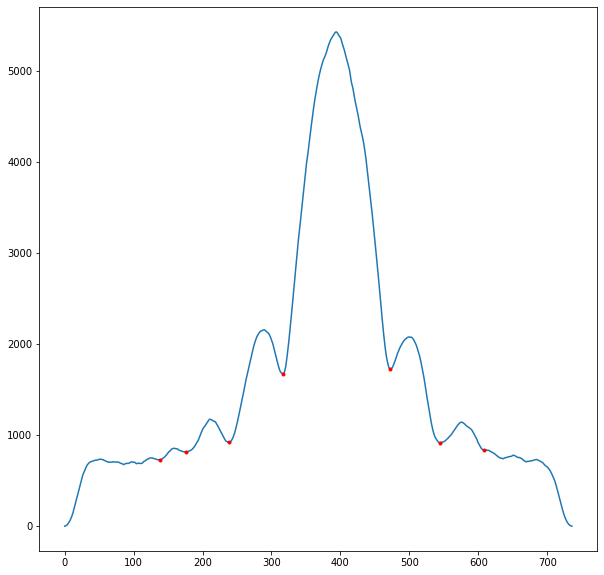

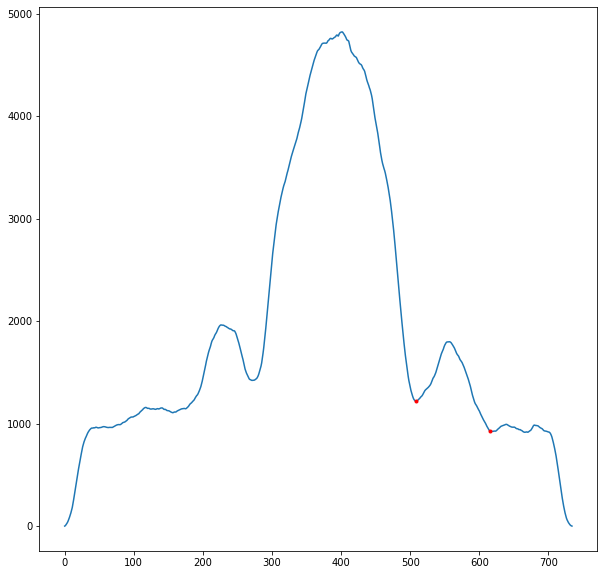

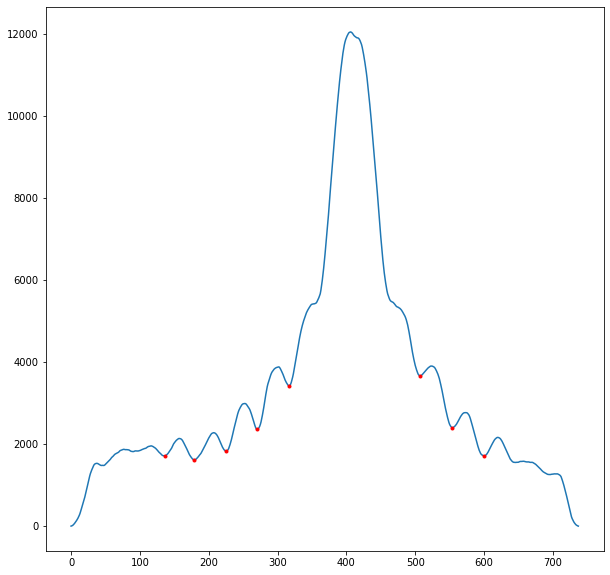

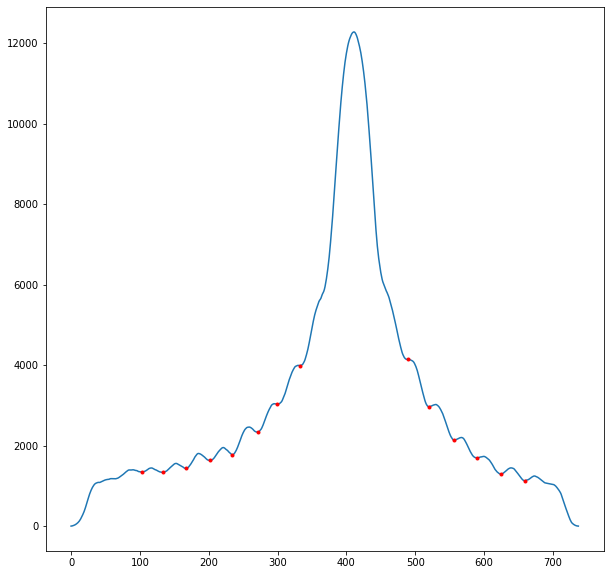

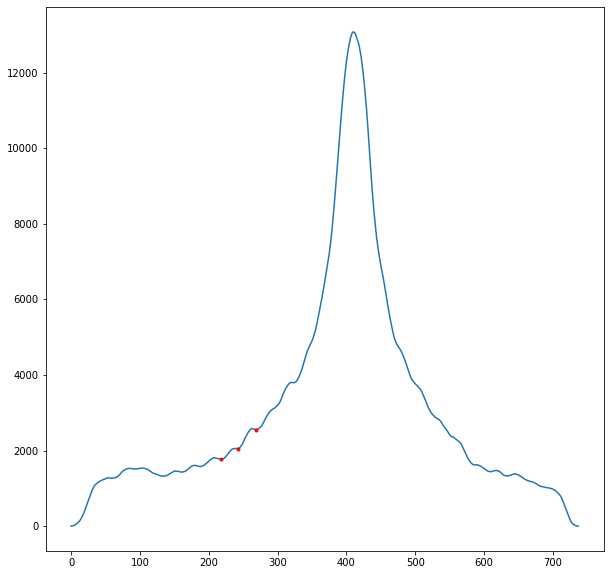

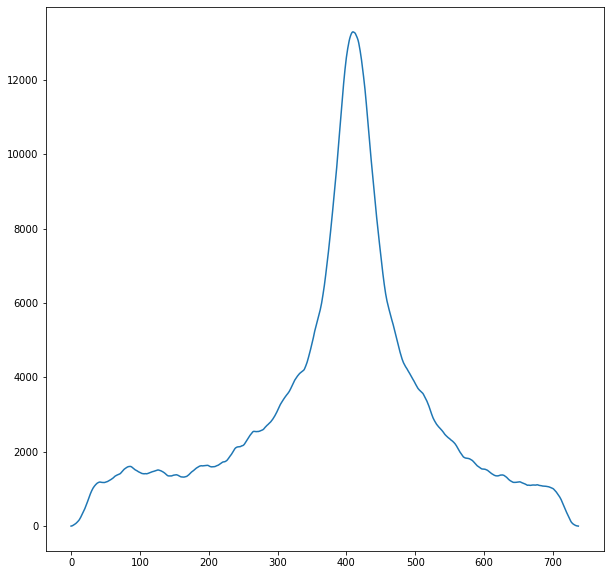

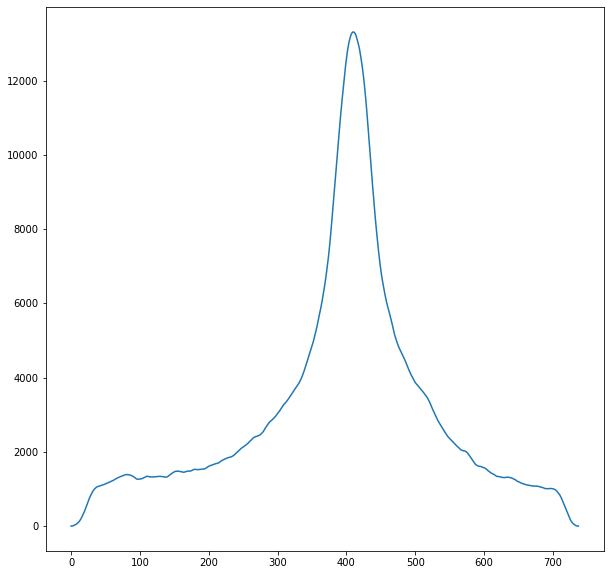

In [65]:
minimos_nuevos[0] = minimos_nuevos[0][1:]
minimos_nuevos[1] = minimos_nuevos[1][7:-2]
minimos_nuevos[2] = minimos_nuevos[2][1:]
minimos_nuevos[3] = minimos_nuevos[3]
minimos_nuevos[4] = minimos_nuevos[4]
minimos_nuevos[5] = minimos_nuevos[5]
minimos_nuevos[6] = minimos_nuevos[6]

for index, imagen in enumerate(imagenes_suavizadas):
    plt.figure(figsize=(10,10))
    plt.plot(imagen)
    plt.plot(minimos_nuevos[index], imagen[minimos_nuevos[index]], '.r')
    plt.show()

## Calculamos las distancias entre los mínimos

Ahora calculo la distancia promedio de los mínimos para cada gráfico

In [92]:
separacion_intermedia = [4, 0, 5, 8, 3, 0, 0] #una lista con la cantidad de mínimos antes del pico del sinc

distancias_promedio = []
errores_promedio = []
for index, minimo in enumerate(minimos_nuevos):
    limite = separacion_intermedia[index]
    if limite != 0:
        primeros = minimo[:limite]
        ultimos = minimo[limite:]
        std_primeros = np.std(np.diff(primeros))
        std_ultimos = np.std(np.diff(ultimos))
        prom_primeros = np.mean(np.diff(primeros))
        prom_ultimos = np.mean(np.diff(ultimos))
        if index != 4:
            distancias_promedio.append(np.mean([prom_primeros, prom_ultimos]))
            errores_promedio.append(np.mean([std_primeros, std_ultimos]))
        else:
            distancias_promedio.append(np.mean(prom_primeros))
            errores_promedio.append(np.mean(std_primeros))
    else:
        distancias_promedio.append(np.mean(np.diff(minimo)))
        errores_promedio.append(0)

print(distancias_promedio)
print(errores_promedio)

#Saco los ultimos dos valores de las listas
distancias_promedio = distancias_promedio[:-2]
errores_promedio = errores_promedio[:-2]

[63.66666666666667, 108.0, 45.875, 33.35714285714286, 25.0, nan, nan]
[11.124899355290408, 0, 0.989509972887452, 2.2436397125049474, 1.0, 0, 0]


Paso las distancias de pixeles a centimetros dividiendo por la escala

In [133]:
distancias_cm = distancias_promedio/escala
errores_cm = errores_promedio/escala
errores_cm[1] = 0.04

print(distancias_cm)
print(errores_cm)

[1.20001283 2.03562386 0.86466893 0.62872774 0.47120923]
[0.20968621 0.04       0.01865065 0.04228895 0.01884837]


## Calculo el ancho de las rendijas

Ahora que tengo las distancias entre los mínimos del patrón de difracción, puedo calcular la separación entre las rendijas, que es el desplazamiento en y(L) de la barra. Para calcular la separación entre las rendijas uso la ecuación $\frac{D \lambda}{a}= \Delta min$ donde $\Delta min$ es la posición entre los mínimos, $D= (189.0 \pm 0.5)cm$ es la distancia entre la rendija y la pantalla, $\lambda = (670 \pm 5)nm$ es la longitud de onda del laser y $a$ es la separación de la rendija. Entonces $a = \frac{D \lambda}{\Delta min}$

In [140]:
import pint

un = pint.UnitRegistry()

D = 189 * un.centimeter
error_D = 0.5 * un.centimeter
long_onda = 670 * un.nanometer
error_long_onda = 5 * un.nanometer

separaciones_rendija = []
for distancia in distancias_cm:
    distancia = distancia * un.centimeter
    num = D * long_onda
    a = num / distancia
    print(a.to(un.micrometer))
    separaciones_rendija.append(a.to(un.micrometer))


105.52387161432871 micrometer
62.20697369857033 micrometer
146.44911519227458 micrometer
201.40673283134547 micrometer
268.7341263778238 micrometer


## Calculo errores

Calculo los errores de las separaciones de las rendijas usando la siguiente ecuación de propagación:

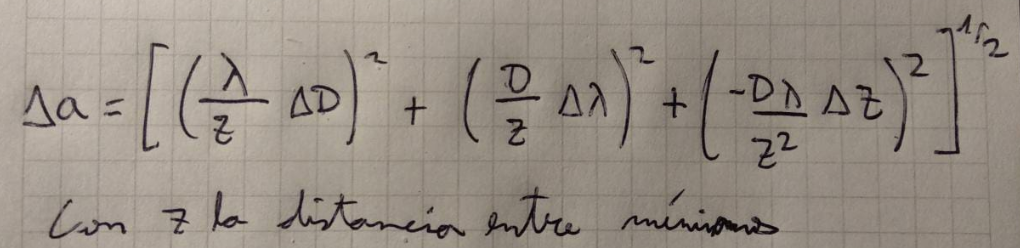

In [143]:

err_separacion_rendija = []
for index, z in enumerate(distancias_cm):
    err_z = errores_cm[index] * un.centimeter
    z = z * un.centimeter
    primero = (long_onda * error_D) / (z)
    segundo = (D * error_long_onda) / (z)
    tercero = (D * long_onda * err_z) / (z**2)
    err_separacion = np.sqrt(primero**2 + segundo**2 + tercero**2)
    err_separacion_rendija.append(err_separacion.to(un.micrometer))
    print(separaciones_rendija[index],err_separacion.to(un.micrometer))
    


105.52387161432871 micrometer 18.457806396162038 micrometer
62.20697369857033 micrometer 1.317867186061931 micrometer
146.44911519227458 micrometer 3.364960651793268 micrometer
201.40673283134547 micrometer 13.6403850883004 micrometer
268.7341263778238 micrometer 10.957929755048557 micrometer


Ahora con estas distancias quiero calcular el módulo de Young usando la ecuación
$$E = \frac{F}{2yI}\left(L x^2 - \frac{x^3}{3}\right) \tag{1}$$
Donde $F=mg$ es la fuerza aplicada, $y=$ separación de la rendija, $L=(30.9 \pm 0.5)cm$ es el largo de la varilla, $I=\frac{\pi r^4}{4}=\frac{\pi d^4}{64}$ es el momento de inercia de la sección transversal de la varilla con $r$ su radio y $d=(4.0 \pm 0.2)mm$ su diámetro, y en este caso $x=L$.

In [152]:
g = 9.807 * un.meter / un.second**2
masas = [3.0912, 1.0043, 4.8188, 6.9318, 9.0212, 11.0755, 13.6564] # en gramos con error 0.0005g en orden de archivo
F = np.array(masas) * un.gram * g
d = 4 * un.millimeter
I = np.pi * d**4 / 64
L = 30.9 * un.centimeter
x = L

E = []
for index, separacion in enumerate(separaciones_rendija):
    num = F[index] * (L * x**2 - x**3 / 3)
    den = 2 * separacion * I
    e = num/den
    e = e.to(un.gigapascal)
    print(e)
    E.append(e.magnitude)


#E.pop(1) # Elimino el dato problemático del segundo gráfico
E = np.array(E)
E_acero = np.mean(E) * un.gigapascal
print("Tomando un promedio de estos valores, el módulo de Young del acero es:",E_acero)

224.83135750527217 gigapascal
123.9095796325467 gigapascal
252.54143527314835 gigapascal
264.15116721197154 gigapascal
257.6451581765838 gigapascal
Tomando un promedio de estos valores, el módulo de Young del acero es: 224.6157395599045 gigapascal


Hago análisis de los errores. La propagación de errores de E es la siguiente

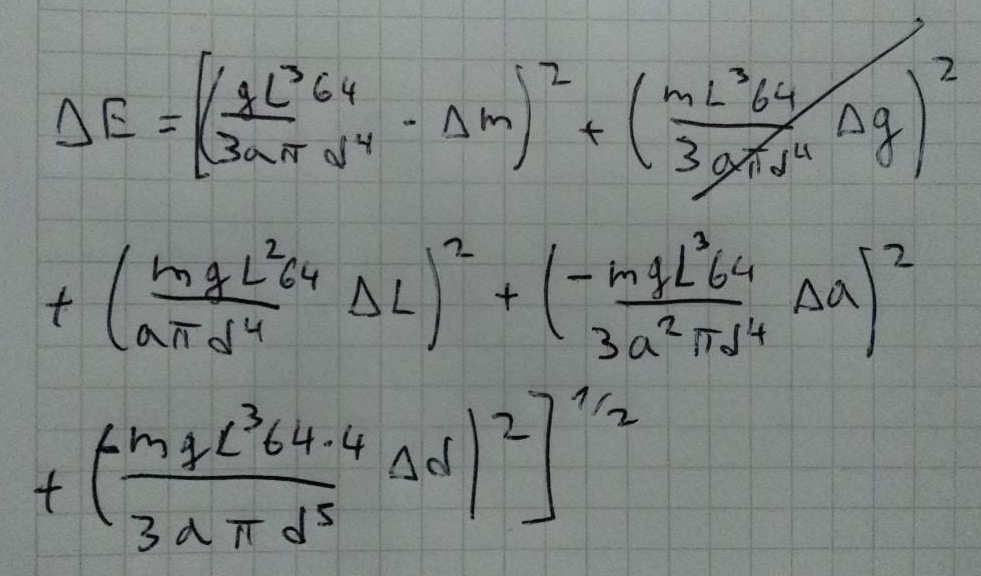

In [153]:
err_L = 0.5 * un.centimeter
err_m = 0.0005 * un.gram
err_g = 0.001 * un.meter / un.second**2
err_d = 0.2 * un.millimeter
#errores_cm[1] = 0.04
errores_cm = np.array(errores_cm) * un.centimeter

errores_E = []
for index, a in enumerate(separaciones_rendija):
    #defino de a términos
    m = masas[index] * un.gram
    err_a = err_separacion_rendija[index]
    primero = (g * L**3 * 64 * err_m) / (3 * a * np.pi * d**4)
    segundo = (m * L**3 * 64 * err_g) / (3 * a * np.pi * d**4)
    tercero = (m * g * L**2 * 64 * err_L) / (a * np.pi * d**4)
    cuarto = (m * g * L**3 * 64 * err_a) / (3 * a**2 * np.pi * d**4)
    quinto = (m * g * L**3 * 64 * 4 * err_d) / (3 * a * np.pi * d**5)
    #print(primero.to(un.pascal)/1e9, segundo.to(un.pascal)/1e9, tercero.to(un.pascal)/1e9, cuarto.to(un.pascal)/1e9, quinto.to(un.pascal)/1e9)
    err_E = np.sqrt(primero**2 + segundo**2 + tercero**2 + cuarto**2 + quinto**2)
    print(E[index], err_E.to(un.gigapascal))
    errores_E.append(err_E.to(un.gigapascal))

224.83135750527217 60.726158771782856 gigapascal
123.9095796325467 25.636278381082857 gigapascal
252.54143527314835 52.29769923893429 gigapascal
264.15116721197154 57.23202949927314 gigapascal
257.6451581765838 54.055890552630935 gigapascal


<ipython-input-153-7000dae38461>:6: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  errores_cm = np.array(errores_cm) * un.centimeter


## Grafico la lineal ancho de la rendija en función de la masa colgada

[3.0912, 1.0043, 4.8188, 6.9318, 9.0212, 11.0755, 13.6564] [105.52387161432871, 62.20697369857033, 146.44911519227458, 201.40673283134547, 268.7341263778238]


/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


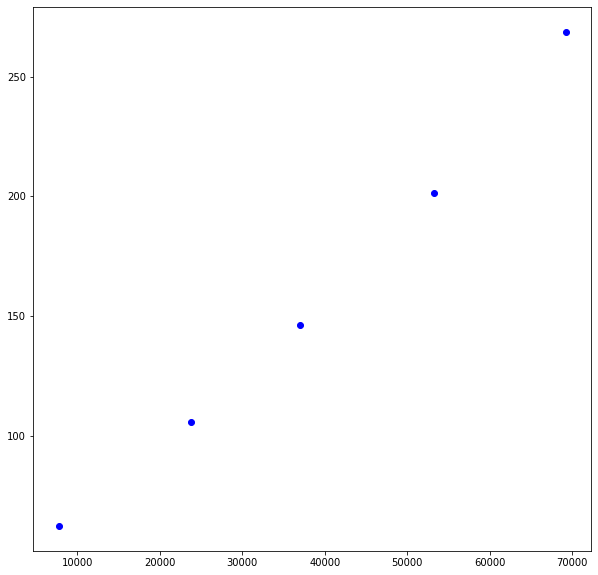

In [159]:
cte = (g * L**3 * 64) / (3 * np.pi * d**4)

plt.figure(figsize=(10,10))
separaciones_rendija_sin_unidades = []
for sep in separaciones_rendija:
    separaciones_rendija_sin_unidades.append(sep.magnitude)
print(masas, separaciones_rendija_sin_unidades)
plt.plot(cte * masas[:-2] , separaciones_rendija_sin_unidades, 'ob')
plt.show()